In [2]:
!pip3 install torchinfo

In [5]:
# Install gdown if not installed
!pip install gdown

# Download the file
file_id = "1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY"
gdown_url = f"https://drive.google.com/uc?id={file_id}"
!gdown {gdown_url}

# Optional: Unzip the file if it's a zip
!unzip -q '*.zip' -d ./dataset

Downloading...
From (original): https://drive.google.com/uc?id=1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY
From (redirected): https://drive.google.com/uc?id=1wosz2L1jboWuGp5_7-I9cSV0iUbIQhQY&confirm=t&uuid=13f25b9a-0dfd-4bd9-a3eb-376e8a9abf25
To: /content/Copy of img_align_celeba.zip
100% 1.44G/1.44G [01:00<00:00, 23.9MB/s]


In [6]:
import torchvision
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torchinfo import summary

In [3]:
# from PIL import Image

# img = Image.open("data/celeba/img_align_celeba/000001.jpg")
# print(img.mode)  # 'RGB' if it's color, 'L' if grayscale
#CelebA is a RGB dataset

In [8]:

transform=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # transform the images as done in the paper
])
data=datasets.ImageFolder(root='dataset',transform=transform)
dataloader=DataLoader(data,batch_size=128,shuffle=True)
next(iter(dataloader))


[tensor([[[[-0.5765,  0.2941,  0.9686,  ...,  0.6471,  0.7412,  0.7882],
           [-0.4980,  0.4902,  0.9765,  ...,  0.6627,  0.7569,  0.7882],
           [-0.3490,  0.6941,  0.9843,  ...,  0.6863,  0.7725,  0.7961],
           ...,
           [-0.8039, -0.7725, -0.7569,  ...,  0.7569,  0.7569,  0.7569],
           [-0.8118, -0.7804, -0.7725,  ...,  0.7725,  0.7725,  0.7725],
           [-0.8039, -0.7804, -0.7804,  ...,  0.7647,  0.7647,  0.7647]],
 
          [[-0.5843,  0.2863,  0.9529,  ...,  0.5373,  0.6627,  0.7098],
           [-0.5059,  0.4745,  0.9608,  ...,  0.5451,  0.6784,  0.7098],
           [-0.3569,  0.6863,  0.9686,  ...,  0.5686,  0.6941,  0.7176],
           ...,
           [-0.7333, -0.7020, -0.6784,  ...,  0.6863,  0.6863,  0.6863],
           [-0.7412, -0.7020, -0.6941,  ...,  0.7020,  0.7020,  0.7020],
           [-0.7333, -0.7020, -0.7020,  ...,  0.6941,  0.6941,  0.6941]],
 
          [[-0.8196,  0.0824,  0.8039,  ...,  0.2706,  0.4353,  0.5294],
           [-

In [9]:
print(len(dataloader))

1583


In [10]:
train_x,train_y=next(iter(dataloader))
print(train_x.shape) #batch_size,channels(depth),W,H

torch.Size([128, 3, 64, 64])


In [11]:
# Initialize weights acc to the paper
#Weights initialized from Normal dist with mean 0, std dev 0.02
def weights_init(m):
  classname=m.__class__.__name__
  if classname.find('Conv')!=-1:
    nn.init.normal_(m.weight.data,0.0,0.02)
  elif classname.find('BatchNorm')!=-1:
    nn.init.normal(m.weight.data,1.0,0.02)
    nn.init.constant_(m.bias.data,0)



### Generator
- fractional strided convolutions
- ReLU activation in generator for all layers except the output, which uses Tanh


In [12]:
class Generator(nn.Module):
  def __init__(self,noise_dim):
    super().__init__()

    self.main=nn.Sequential(
        nn.ConvTranspose2d(in_channels=noise_dim,out_channels=1024,kernel_size=4,stride=2,padding=0,bias=False), #(N,z_dim,1,1) -> N,1024,4,4)
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False), # (N,1024,4,4) -> (N,512,8,8)
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),#(N,512,8,8) -> (N,256,16,16)
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False), #(N,256,16,16) -> (N,128,32,32)
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128,out_channels=3,kernel_size=4,stride=2,padding=1,bias=False), #(N,128,32,32) ->  (N, 3, 64, 64)
        nn.Tanh()

    )

  def forward(self,z):
    return self.main(z)

generator_test=Generator(noise_dim=100 )

# Generate random noise (N, z_dim, 1, 1)
noise = torch.randn(16, 100, 1, 1)
with torch.no_grad():
    fake_images = generator_test(noise)
print(fake_images.shape) #torch.Size([16, 3, 64, 64]) correct shape
summary(model=generator_test,
        input_size=(128, 100, 1, 1),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


torch.Size([16, 3, 64, 64])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
├─Sequential (main)                      [128, 100, 1, 1]     [128, 3, 64, 64]     --                   True
│    └─ConvTranspose2d (0)               [128, 100, 1, 1]     [128, 1024, 4, 4]    1,638,400            True
│    └─BatchNorm2d (1)                   [128, 1024, 4, 4]    [128, 1024, 4, 4]    2,048                True
│    └─ReLU (2)                          [128, 1024, 4, 4]    [128, 1024, 4, 4]    --                   --
│    └─ConvTranspose2d (3)               [128, 1024, 4, 4]    [128, 512, 8, 8]     8,388,608            True
│    └─BatchNorm2d (4)                   [128, 512, 8, 8]     [128, 512, 8, 8]     1,024                True
│    └─ReLU (5)                          [128, 512, 8, 8]     [128, 512, 8, 8]     --                   --
│    └─ConvTranspo

### Discriminator

In [13]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.main=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False), # (N,3,64,64) -> (N,64,32,32)
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False), #(N,64,32,32) -> (N,128,16,16)
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False), #(N,128,16,16) -> (N,256,8,8)
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=2,padding=0,bias=False),
        nn.Flatten(),
        nn.Sigmoid()


    )

  def forward(self,img):
    return self.main(img)

disc_test=Discriminator()
test_input = torch.randn(16, 3, 64, 64)
with torch.no_grad():
    test_output = disc_test(test_input)
print(test_output.shape)
summary(model=disc_test,
        input_size=(16,3,64,64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

torch.Size([16, 1])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Discriminator (Discriminator)            [16, 3, 64, 64]      [16, 1]              --                   True
├─Sequential (main)                      [16, 3, 64, 64]      [16, 1]              --                   True
│    └─Conv2d (0)                        [16, 3, 64, 64]      [16, 64, 32, 32]     3,072                True
│    └─LeakyReLU (1)                     [16, 64, 32, 32]     [16, 64, 32, 32]     --                   --
│    └─Conv2d (2)                        [16, 64, 32, 32]     [16, 128, 16, 16]    131,072              True
│    └─BatchNorm2d (3)                   [16, 128, 16, 16]    [16, 128, 16, 16]    256                  True
│    └─LeakyReLU (4)                     [16, 128, 16, 16]    [16, 128, 16, 16]    --                   --
│    └─Conv2d (5)                        [16, 128, 16, 16]    [16, 256, 8, 8]      524,288              True
│    └─BatchNorm2d

### Init

In [14]:
batch_size=128
noise_dim=100

device='cuda' if torch.cuda.is_available() else "cpu"
fixed_noise = torch.randn((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device)
generator=Generator(noise_dim).to(device)
generator.apply(weights_init)

discriminator=Discriminator().to(device)
discriminator.apply(weights_init)

<ipython-input-11-46c102b4a28d>:8: FutureWarning: `nn.init.normal` is now deprecated in favor of `nn.init.normal_`.
  nn.init.normal(m.weight.data,1.0,0.02)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Sigmoid()
  )
)

### Training

In [16]:
epochs=7
beta_1=0.5
lr=0.0002
criterion = nn.BCELoss()
disc_optim = torch.optim.Adam(params=discriminator.parameters(), betas=(beta_1, 0.999), lr=lr)
gen_optim = torch.optim.Adam(params=generator.parameters(), betas=(beta_1, 0.999), lr=lr)

loss_gen=[]
loss_disc=[]
fixed_noise = torch.randn((batch_size, 100, 1, 1), dtype=torch.float32, device=device)
print(fixed_noise.shape)



torch.Size([128, 100, 1, 1])


In [17]:
for epoch in range(epochs):
  for batch,(x,y) in enumerate(dataloader):
    x=x.to(device)
    batch_size=x.shape[0]

    ##Training the discriminator
    noise=torch.randn((batch_size,noise_dim,1,1)).to(device)
    fake=generator(noise)
    disc_real=discriminator(x)
    lossD_real=criterion(disc_real,torch.ones_like(disc_real)) # log(D(x))
    disc_fake=discriminator(fake) #D(G(x))
    lossD_fake=criterion(disc_fake,torch.zeros_like(disc_fake)) # log(1-D(G(x)))
    lossD=(lossD_real + lossD_fake) / 2

    discriminator.zero_grad()
    lossD.backward(retain_graph=True) #llows the generator’s computation graph to be reused after the discriminator’s backward pass
    disc_optim.step()

    ## Train the generator min log(1 - D(G(z))) <-> max log(D(G(z))
    output = discriminator(fake).view(-1)
    lossG = criterion(output, torch.ones_like(output))
    generator.zero_grad()
    lossG.backward()
    gen_optim.step()

    loss_gen.append(lossG.item())
    loss_disc.append(lossD.item())
    if batch == 0:
        print(
            f"Epoch [{epoch}/{epochs}] Batch {batch}/{len(dataloader)} \
                    Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
        )







Epoch [0/7] Batch 0/1583                     Loss D: 0.9526, loss G: 6.5727
Epoch [1/7] Batch 0/1583                     Loss D: 0.4020, loss G: 2.1266
Epoch [2/7] Batch 0/1583                     Loss D: 0.4100, loss G: 1.4513
Epoch [3/7] Batch 0/1583                     Loss D: 0.5090, loss G: 1.1764
Epoch [4/7] Batch 0/1583                     Loss D: 0.5154, loss G: 1.1971
Epoch [5/7] Batch 0/1583                     Loss D: 0.4297, loss G: 1.4365
Epoch [6/7] Batch 0/1583                     Loss D: 0.4203, loss G: 2.8978


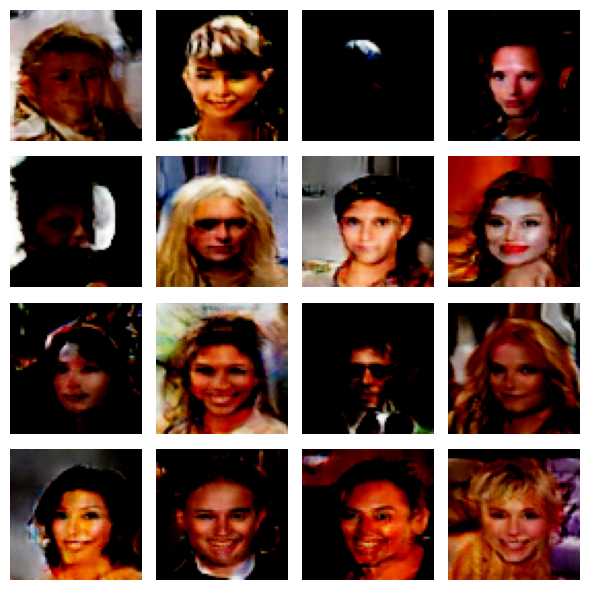

In [22]:
import matplotlib.pyplot as plt

fixed_noise = torch.randn((batch_size, noise_dim, 1, 1), dtype=torch.float32, device=device)
generator.eval()
with torch.no_grad():
    fake_images = generator(noise)

# Move fake_images to CPU before plotting
fake_images = fake_images.cpu()  # Add this line

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    # Permute from (C, H, W) to (H, W, C)
    img = fake_images[i].permute(1, 2, 0)
    ax.imshow(img, cmap="gray" if img.shape[-1] == 1 else None)
    ax.axis("off")

plt.tight_layout()
plt.show()